# Network component analysis

In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from networkx.algorithms import community
from tqdm import tqdm
import copy
from time import perf_counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)

## Load the data (sampled) and create NetworkX graphs

In [82]:
edgelists = {}
nx_graphs = {}

for file in Path("edgelistsSample").iterdir():
    tmp_edgelist = pd.read_csv(file)
    edgelists[file.stem] = tmp_edgelist

    tmp_nx_graph = nx.from_pandas_edgelist(tmp_edgelist, source='Source', target='Target', create_using=nx.Graph())
    # Ensure that graphs have a 'weight' edge attribute
    nx.set_edge_attributes(tmp_nx_graph, 1, 'weight')
    nx_graphs[file.stem] = tmp_nx_graph

## Our Louvain implementation

In [83]:
# Louvain implementation
def louvain(G, npassage):
    # Will contain the graph and the communities after each passage
    data = {}
    for i in range(0, npassage):
        print(f"Passage {i+1}", flush=True)
        G, communities, get_community = louvain_step(G, i==0)
        data[i] = get_community
        print(f"There are {len(communities)} communities after passage {i+1}", flush=True)
    return data


def louvain_step(G, is_first_passage):
    # Step 1: Initialization, start with each node being a single community
    communities = {idx: set([node]) for idx, node in enumerate(G.nodes)}
    # To get direct access to the community (it speeds up a bit the algorithm)
    get_community = {node: idx for idx, node in enumerate(G.nodes)}
    # Used in the modularity computation
    neighbors_sets = {node: set(G.neighbors(node)) for node in G.nodes}
    m = len(G.edges)

    # Sum the weights of the incident edges for all nodes inside a community, for all communities
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        sum_communities = {idx: sum(dict(G.degree(community)).values()) for idx, community in communities.items()}
    else:
        sum_communities = {idx: sum(dict(G.degree(community, 'weight')).values()) for idx, community in communities.items()}

    prev_communities = {}
    i = 0
    # While there are changes in the communities, make another iteration
    while(communities != prev_communities):
        print(f"Iteration {i+1}", flush=True)
        # Deepcopy to have a new object with a new reference
        # Otherwise comparison in while is always True
        prev_communities = copy.deepcopy(communities)
        
        for node in tqdm(G.nodes):
            # Step 2: Remove node from its community
            neighboring_communities = get_neighboring_communities(G, node, get_community)
            if neighboring_communities == set():
                continue
            belong_to = get_community[node]
            communities[belong_to].remove(node)
            sum_communities[belong_to] -= G.degree(node, 'weight')
            if communities[belong_to] == set():
                del communities[belong_to]
                del sum_communities[belong_to]

            # Step 3: Insert the node in the community that maximizes the modularity
            scores = [
                (neighbor_community, modularity_gain(G, node, communities[neighbor_community], sum_communities[neighbor_community], neighbors_sets[node], m, is_first_passage))
                for neighbor_community in neighboring_communities
            ]
            best_community, best_score = max(scores, key=lambda x: x[1])
            communities[best_community].add(node)
            get_community[node] = best_community
            sum_communities[best_community] += G.degree(node, 'weight')
          
        i += 1

    # Step 4: Update the graph
    if is_first_passage:
        return get_new_graph(G, communities, sum_communities, get_community), communities, get_community
    return get_new_graph(G, communities, sum_communities, get_community), communities, get_community


def get_neighboring_communities(G, node, get_community):
    # Use a set to make sure a community only appear once
    neighboring_communities = set()
    for neighbor in G.neighbors(node):
        if neighbor == node: continue
        neighboring_communities.add(get_community[neighbor])
    return neighboring_communities


def modularity_gain(G, node, community, sum_community, neighbor_set, m, is_first_passage):
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        # Sum the weights of the edges from node into community nodes
        # Using sets allow to use intersection()
        sum_weights_node = len(neighbor_set.intersection(community))
        right_member = (sum_community * G.degree[node]) / (2 * (m**2))
    else:
        # Sum the weights of the edges from node into community nodes
        sum_weights_node = sum([G.get_edge_data(node, member)['weight'] for member in G.neighbors(node) if member in community])
        right_member = (sum_community * G.degree(node, 'weight')) / (2 * (m**2))
    # Compute modularity
    left_member = sum_weights_node / (2 * m)
    return left_member - right_member


def get_new_graph(old_G, communities, sum_communities, get_community):
    print("Constructing new graph", flush=True)
    G = nx.Graph()
    G.add_nodes_from(communities.keys())
    for community in communities:
        G.add_edge(community, community, weight=sum_communities[community])

    for source, dest, weight_dict in old_G.edges(data=True):
        community1 = get_community[source]
        community2 = get_community[dest]
        # If edge not exist, weight initialized at 0
        current_weight = G.get_edge_data(community1, community2, {'weight': 0})['weight']
        new_weight = current_weight + weight_dict['weight']
        G.add_edge(community1, community2, weight=new_weight)
    return G

## Run our Louvain on the graphs

In [84]:
results = {}
for name, G in nx_graphs.items():
    print(f"Louvain on {name}")
    data = louvain(G, 2)
    results[name] = data
    print(f"\n")

Louvain on edgelists_any_sample
Passage 1
Iteration 1


100%|██████████| 375247/375247 [00:13<00:00, 28418.41it/s]

Iteration 2



100%|██████████| 375247/375247 [00:11<00:00, 31291.22it/s]

Iteration 3



100%|██████████| 375247/375247 [00:10<00:00, 34561.80it/s]

Iteration 4



100%|██████████| 375247/375247 [00:11<00:00, 33582.33it/s]

Constructing new graph


There are 100 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 100/100 [00:00<00:00, 3104.52it/s]

Iteration 2



100%|██████████| 100/100 [00:00<00:00, 3021.16it/s]

Iteration 3



100%|██████████| 100/100 [00:00<00:00, 4523.33it/s]

Iteration 4



100%|██████████| 100/100 [00:00<00:00, 6574.87it/s]

Iteration 5



100%|██████████| 100/100 [00:00<00:00, 5189.81it/s]

Iteration 6



100%|██████████| 100/100 [00:00<00:00, 5806.47it/s]

Iteration 7



100%|██████████| 100/100 [00:00<00:00, 4308.17it/s]

Iteration 8



100%|██████████| 100/100 [00:00<00:00, 7708.13it/s]

Iteration 9



100%|██████████| 100/100 [00:00<00:00, 6621.57it/s]

Iteration 10



100%|██████████| 100/100 [00:00<00:00, 6297.94it/s]

Constructing new graph
There are 37 communities after passage 2




Louvain on edgelists_liking_sample
Passage 1
Iteration 1


100%|██████████| 350872/350872 [00:12<00:00, 28719.86it/s]

Iteration 2



100%|██████████| 350872/350872 [00:11<00:00, 30424.75it/s]

Iteration 3



100%|██████████| 350872/350872 [00:10<00:00, 33953.86it/s]

Iteration 4



100%|██████████| 350872/350872 [00:10<00:00, 34075.87it/s]

Constructing new graph


There are 100 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 100/100 [00:00<00:00, 3801.05it/s]

Iteration 2



100%|██████████| 100/100 [00:00<00:00, 4183.93it/s]

Iteration 3



100%|██████████| 100/100 [00:00<00:00, 7213.28it/s]

Iteration 4



100%|██████████| 100/100 [00:00<00:00, 9214.40it/s]

Iteration 5



100%|██████████| 100/100 [00:00<00:00, 6181.55it/s]

Iteration 6



100%|██████████| 100/100 [00:00<00:00, 14860.24it/s]

Iteration 7



100%|██████████| 100/100 [00:00<00:00, 12821.52it/s]

Iteration 8



100%|██████████| 100/100 [00:00<00:00, 12039.80it/s]

Iteration 9



100%|██████████| 100/100 [00:00<00:00, 9857.59it/s]

Iteration 10



100%|██████████| 100/100 [00:00<00:00, 8073.73it/s]

Constructing new graph


There are 32 communities after passage 2


Louvain on edgelists_retweeters_sample
Passage 1
Iteration 1


100%|██████████| 83303/83303 [00:02<00:00, 31173.83it/s]

Iteration 2



100%|██████████| 83303/83303 [00:04<00:00, 18859.62it/s]

Iteration 3



100%|██████████| 83303/83303 [00:02<00:00, 39840.14it/s]

Iteration 4



100%|██████████| 83303/83303 [00:02<00:00, 39861.48it/s]

Constructing new graph


There are 100 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 100/100 [00:00<00:00, 9358.94it/s]

Iteration 2



100%|██████████| 100/100 [00:00<00:00, 13771.23it/s]

Iteration 3



100%|██████████| 100/100 [00:00<00:00, 13229.16it/s]

Iteration 4



100%|██████████| 100/100 [00:00<00:00, 99959.58it/s]

Iteration 5



100%|██████████| 100/100 [00:00<00:00, 6097.70it/s]

Iteration 6



100%|██████████| 100/100 [00:00<00:00, 18806.01it/s]

Iteration 7



100%|██████████| 100/100 [00:00<00:00, 6884.71it/s]

Iteration 8



100%|██████████| 100/100 [00:00<00:00, 15150.64it/s]

Iteration 9



100%|██████████| 100/100 [00:00<00:00, 14101.34it/s]

Iteration 10



100%|██████████| 100/100 [00:00<00:00, 18508.91it/s]

Iteration 11



100%|██████████| 100/100 [00:00<00:00, 16998.19it/s]

Iteration 12



100%|██████████| 100/100 [00:00<00:00, 22973.68it/s]

Iteration 13



100%|██████████| 100/100 [00:00<00:00, 9521.91it/s]

Iteration 14



100%|██████████| 100/100 [00:00<00:00, 10140.72it/s]

Constructing new graph
There are 43 communities after passage 2


## Export and save label communities of each node (for Gephi)

In [85]:
Path.mkdir(Path("analysis"), exist_ok=True)

# Get the label communities for the nodes for each passage
for name, result in results.items():
    intermediate_results = []

    for i in range(len(result)-1, -1, -1):
        if i == 0:
            break
        curr = result[i]
        prev = result[i-1]
        intermediate_result =  {node: curr[val] for node, val in prev.items()}
        intermediate_results.append(intermediate_result)
    
    try:
        commu = intermediate_results[-1]
    # If we run only for one passage
    except IndexError:
        commu = result[0]

    communities_df = pd.DataFrame(commu.items(), columns=['Id', 'Community'])
    communities_df["Label"] = communities_df["Id"].map(lambda x: x)
    communities_df["Is_author"] = False

    communities_df.loc[communities_df['Id'].isin(edgelists[name]['Target'].unique()), "Is_author"] = True

    communities_df.to_csv(f"analysis/communities_{name}.csv", index=False)

## Comparing the 3 results

In [2]:
df_result_any = pd.read_csv("analysis/communities_edgelists_any_sample.csv")
df_result_like = pd.read_csv("analysis/communities_edgelists_liking_sample.csv")
df_result_retweet = pd.read_csv("analysis/communities_edgelists_retweeters_sample.csv")

### Some stats

In [3]:
n_any = len(df_result_any['Id'].unique())
n_retweet = len(df_result_retweet['Id'].unique())
n_like = len(df_result_like['Id'].unique())

print(f"Number of nodes in any: {n_any}")
print(f"Number of nodes in retweet: {n_retweet}")
print(f"Number of nodes in like: {n_like}")

Number of nodes in any: 375247
Number of nodes in retweet: 83303
Number of nodes in like: 350872


In [4]:
n_unique_any = len(df_result_any['Community'].unique())
n_unique_retweet = len(df_result_retweet['Community'].unique())
n_unique_like = len(df_result_like['Community'].unique())

print(f"Number of unique communities in any: {n_unique_any}")
print(f"Number of unique communities in retweet: {n_unique_retweet}")
print(f"Number of unique communities in like: {n_unique_like}")

Number of unique communities in any: 37
Number of unique communities in retweet: 43
Number of unique communities in like: 32


In [5]:
intersection_ids = set(df_result_like['Id'].unique()).intersection(set(df_result_retweet['Id'].unique()))

print(f"Number of nodes in the intersection between like and retweet: {len(intersection_ids)}")

Number of nodes in the intersection between like and retweet: 58928


In [6]:
# Number of nodes for each community
df_result_any.groupby('Community')["Id"].count().sort_values(ascending=False)

Community
37    222915
89     86046
62      7934
47      6639
88      6608
35      6379
81      5327
72      4826
86      4749
67      4716
80      4713
93      4672
77      4669
58      4518
48       367
97        41
60        17
98        14
8         14
99        10
9          9
94         9
92         8
24         7
36         7
73         6
69         5
40         4
2          3
90         2
68         2
29         2
31         2
96         2
66         2
30         2
42         1
Name: Id, dtype: int64

In [7]:
# Percentage of the total nodes
df_result_any.groupby('Community')["Id"].count().sort_values(ascending=False).div(n_any).mul(100)

Community
37    59.404872
89    22.930496
62     2.114341
47     1.769235
88     1.760973
35     1.699947
81     1.419598
72     1.286086
86     1.265566
67     1.256772
80     1.255973
93     1.245047
77     1.244247
58     1.204007
48     0.097802
97     0.010926
60     0.004530
98     0.003731
8      0.003731
99     0.002665
9      0.002398
94     0.002398
92     0.002132
24     0.001865
36     0.001865
73     0.001599
69     0.001332
40     0.001066
2      0.000799
90     0.000533
68     0.000533
29     0.000533
31     0.000533
96     0.000533
66     0.000533
30     0.000533
42     0.000266
Name: Id, dtype: float64

### Plots

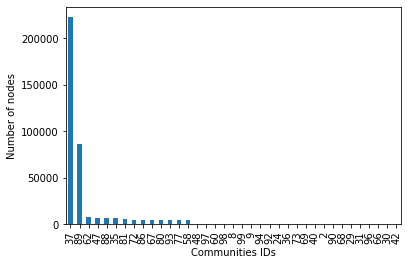

In [8]:
# Bar plot of the number of nodes in each community
df_result_any.groupby('Community')["Id"].count().sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Communities IDs")
plt.ylabel("Number of nodes")
plt.savefig("analysis/nodes_in_each_community.pdf", bbox_inches='tight')

    Degree        Id
0        1  0.936716
1        2  0.055004
2        3  0.006644
3        4  0.001125
4        5  0.000213
..     ...       ...
73     129  0.000003
74     132  0.000003
75     139  0.000003
76     140  0.000003
77  239987  0.000003

[78 rows x 2 columns]


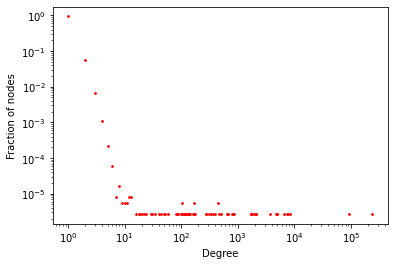

In [49]:
# Plot the degree distribution
gephi_data = pd.read_csv(Path("analysis") / "gephistats.csv")
test = gephi_data.groupby('Degree')["Id"].count().sort_values(ascending=False).div(n_any).to_frame().reset_index()
test.plot(x='Degree', y='Id', kind='scatter', logx=True, logy=True, s=3, c='red')
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")
plt.savefig("analysis/degree_distribution.pdf", bbox_inches='tight')

### Take only the authors from the results

In [8]:
df_result_like_only_authors = df_result_like[df_result_like['Is_author'] == True]
df_result_retweet_only_authors = df_result_retweet[df_result_retweet['Is_author'] == True]
df_result_any_only_authors = df_result_any[df_result_any['Is_author'] == True]

n_unique_like_only_authors = len(df_result_like_only_authors['Id'].unique())
n_unique_retweet_only_authors = len(df_result_retweet_only_authors['Id'].unique())

print(f"Number of unique authors in like only authors: {n_unique_like_only_authors}")
print(f"Number of unique authors in retweet only authors: {n_unique_retweet_only_authors}")

Number of unique authors in like only authors: 100
Number of unique authors in retweet only authors: 100


In [9]:
# create a list of all the authors and call the Twitter API
authors = list(df_result_any_only_authors["Id"].unique())
res = client.get_users(ids=authors, user_fields=["public_metrics", "verified"])

In [10]:
for user_detail in res.data:
    df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'Username'] = user_detail['username']
    df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
    df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'followers_count'] = user_detail['public_metrics']['followers_count']
    df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'following_count'] = user_detail['public_metrics']['following_count']
    df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'tweet_count'] = user_detail['public_metrics']['tweet_count']

/tmp/ipykernel_9057/99766956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'Username'] = user_detail['username']
/tmp/ipykernel_9057/99766956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_any_only_authors.loc[df_result_any_only_authors['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
/tmp/ipykernel_9057/99766956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [11]:
df_result_any_only_authors

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
1,1489241986389651458,62,1489241986389651458,True,Breakin62278210,False,212.0,51.0,580.0
6,363601382,86,363601382,True,healthonaplate,False,1201.0,3783.0,3776.0
1023,1466829518274969609,58,1466829518274969609,True,BrexitPirates,False,3349.0,3018.0,13895.0
1444,44909158,2,44909158,True,Speramus,False,2091.0,904.0,23101.0
1448,44574528,67,44574528,True,HarrisonTF,False,2029.0,1698.0,62066.0
...,...,...,...,...,...,...,...,...,...
349614,2159907348,88,2159907348,True,Smilan317,False,56232.0,36296.0,646389.0
349645,783149246178553856,99,783149246178553856,True,GamerGalsRT,False,7794.0,2109.0,240845.0
349652,210750170,86,210750170,True,phreakoutaston,False,81.0,350.0,1234.0
349714,1121353898126606337,90,1121353898126606337,True,Mycupsofcoffee,False,66.0,31.0,1356.0


In [12]:
# Authors lists for each community
df_result_any_only_authors.groupby('Community')['Username'].apply(lambda x: x.tolist())

Community
2                                            [Speramus]
8                                        [MarjoOinonen]
9                                           [AlAkBseth]
24                                         [MurphKathy]
29                                    [AfricanWatchman]
30                                    [SASSandATTITUDE]
31                                      [AthulJohnson8]
35             [Jawalansheel, PKB_Canada, tejaschogale]
36                                           [deomanyt]
37                           [gurico0516, CyberRealms1]
40                                     [TelanganaToday]
42                                         [victoramle]
47                    [Victor_Vas_Her, PatriciaSomer11]
48                         [BooBooBearsNFT, itayariel1]
58                [BrexitPirates, evilcos, annabotting]
60                                             [IAC_MD]
62         [Breakin62278210, ukraini239540, CRYPTOS369]
66                                    

### Retrieve authors info for the two biggest communities

In [13]:
df_result_any_only_authors[df_result_any_only_authors['Community'] == 37]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
3333,982830096925917184,37,982830096925917184,True,gurico0516,False,1007.0,737.0,540.0
237668,1460159240782462984,37,1460159240782462984,True,CyberRealms1,False,1380.0,0.0,10160.0


In [14]:
df_result_any_only_authors[df_result_any_only_authors['Community'] == 89]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
2152,445184492,89,445184492,True,BPSGroup,False,3910.0,4547.0,122054.0
251519,41014243,89,41014243,True,qvalemangusta,False,1777.0,1228.0,144739.0
257411,1014514281642102785,89,1014514281642102785,True,OurReclaim,False,1413.0,380.0,147317.0
257514,1358713872228753408,89,1358713872228753408,True,mustefa_salim,False,828.0,703.0,14160.0
264473,221644660,89,221644660,True,WWalkerWW,False,2077.0,5001.0,109117.0
340079,2149769419,89,2149769419,True,epaphotos,False,13666.0,1782.0,18890.0
349529,45882349,89,45882349,True,boijingle,False,659.0,1212.0,28993.0


## Comparison between our implementation and the one from NetworkX

In [98]:
results = {}
for name, G in nx_graphs.items():
    print(f"Graph of {len(G.nodes)} nodes")
    
    start_net = perf_counter()
    louvain_nx = community.louvain_partitions(G)
    first = next(louvain_nx)
    stop_net = perf_counter()
    print(f"After first passage: {len(first)} communities")
    # second = next(louvain_nx)
    # print(f"After second passage: {len(second)} communities")
    # third = next(louvain_nx)
    # print(f"After third passage: {len(third)} communities")
    print(f"Time for NetworkX: {stop_net - start_net}")
    
    start_our = perf_counter()
    print(f"Louvain on {name}")
    data = louvain(G, 1)
    stop_our = perf_counter()
    print(f"Time for our implementation: {stop_our - start_our}")
    results[name] = data

Graph of 375247 nodes
After first passage: 100 communities
Time for NetworkX: 29.213629999999284
Louvain on edgelists_any_sample
Passage 1
Iteration 1


100%|██████████| 375247/375247 [00:14<00:00, 25661.33it/s]

Iteration 2



100%|██████████| 375247/375247 [00:11<00:00, 34082.38it/s]

Iteration 3



100%|██████████| 375247/375247 [00:11<00:00, 33998.23it/s]

Iteration 4



100%|██████████| 375247/375247 [00:10<00:00, 35020.22it/s]

Constructing new graph


There are 100 communities after passage 1
Time for our implementation: 66.32583280000017
Graph of 350872 nodes


KeyboardInterrupt: 